In [1]:
#Importing packages
#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [ ]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib

In [3]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("C:\\Users\\A\\Desktop\\Bioactive\\HSV-1")

In [4]:
def Model_results(Model_clf,X_test,y,Cv_model):
    Model_scores= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=True)
    Model_score= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=False)
#Accuracy
    Model_Accuracy_test_mean=Model_scores['test_accuracy'].mean()
    Model_Accuracy_test_se=(Model_scores['test_accuracy'].std()/math.sqrt(len(Model_scores['test_accuracy']))) 
    Model_Accuracy_train_mean=Model_scores['train_accuracy'].mean()
    Model_Accuracy_train_se=(Model_scores['train_accuracy'].std()/math.sqrt(len(Model_scores['train_accuracy']))) 
#f1
    Model_f1_mean=Model_score['test_f1'].mean()
    Model_f1_se=(Model_score['test_f1'].std()/math.sqrt(len(Model_score['test_f1']))) 
#precision
    Model_precision_mean=Model_score['test_precision'].mean()
    Model_precision_se=(Model_score['test_precision'].std()/math.sqrt(len(Model_score['test_precision']))) 
#recall
    Model_recall_mean=Model_score['test_recall'].mean()
    Model_recall_se=(Model_score['test_recall'].std()/math.sqrt(len(Model_score['test_recall']))) 
#roc_auc
    Model_roc_auc_mean=Model_score['test_roc_auc'].mean()
    Model_roc_auc_se=(Model_score['test_roc_auc'].std()/math.sqrt(len(Model_score['test_roc_auc']))) 
    Model = {'Mean':[Model_Accuracy_test_mean,Model_Accuracy_train_mean,Model_f1_mean,Model_precision_mean,Model_recall_mean,Model_roc_auc_mean],
        'Se':[Model_Accuracy_test_se,Model_Accuracy_train_se,Model_f1_se,Model_precision_se,Model_recall_se,Model_roc_auc_se]}
    Model = pd.DataFrame(Model, index=['Accuracy_test','Accuracy_train','F1 Score','Precision','Recall','Roc_auc']) # 这里设定了 index 个数要和列表长度一致
    return Model

In [5]:
Cv_optuna= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [7]:
#Reading the data
ML_data= pd.read_csv("./ML_data.csv",header=0,index_col=0)
X_NAomit_data= pd.read_csv("./X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./Original_data.csv',index_col=0)
#original data(descriptors= 4175）
print(X_NAomit_data.shape)
X_NAomit_data.head()

(5506, 3719)


,MW,AMW,Se,Sp,Si,Me,Mp,Mi,GD,nAT,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
cid,,,,,,,,,,,,,,,,,,,,,
596.0,575.85,6.398333,89.9047,54.3018,103.2543,0.998941,0.603353,1.147270,0.052439,90.0,...,0.0,4.0,8.0,0.0,35.7,0.870732,9.900,0.241463,36.410500,9.464711
1318.0,286.71,11.468400,26.5637,18.6192,27.9438,1.062548,0.744768,1.117752,0.124183,25.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000
1570.0,307.28,8.779429,36.6945,22.7556,39.4553,1.048414,0.650160,1.127294,0.108225,35.0,...,0.0,0.0,2.0,6.0,19.0,0.863636,6.625,0.301136,20.285139,6.320154
1821.0,282.29,8.302647,35.4617,21.1023,39.1162,1.042991,0.620656,1.150476,0.115789,34.0,...,0.0,0.0,0.0,10.0,17.0,0.850000,7.750,0.387500,19.586399,8.618182
2199.0,418.50,8.718750,48.6580,34.5683,53.0758,1.013708,0.720173,1.105746,0.075862,48.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000


In [8]:
Raw_data

,IsomericSMILES,Activity,Canonical_smiles
cid,,,
596.0,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O,0,CC(C)CCCCCCCCCCCCC(=O)NCC(=O)NC1C(C)OC(Nc2ncnc...
1318.0,C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1,1,NC1=C(Cl)C(=O)c2ccc(S(N)(=O)=O)cc2C1=O
1570.0,C1=CC(=S)N(C=C1)O,1,O=C1NC2C(=CC(O)C(O)C2O)c2cc3c(c(O)c21)OCO3
1821.0,C1=C(C(=O)NC(=O)N1C2C(C(C(O2)CO)O)O)F,1,OCC1OC(n2ccc3c(NO)ncnc32)C(O)C1O
2199.0,CC(=O)OC1C(CNC1CC2=CC=C(C=C2)OC)O,1,Cc1ccc(S(=O)(=O)/N=C2\C=C(Nc3ccc(O)cc3)C(=O)c3...
...,...,...,...
135831485.0,CC(=O)C1=CC=C(C=C1)NC(=O)CSC2=NC3=C(C=NN3)C(=O)N2,0,COc1ccc(NC(=O)CSc2nc(O)cc(=O)n2-c2ccccc2OC)cc1
135900555.0,CC(=O)NC1=CC=C(C=C1)NC(=O)CSC2=NC(=C(C(=O)N2)N...,0,COc1ccc(NC(=O)CSc2ncnc3c2cnn3Cc2ccccc2)cc1
135976680.0,C1=CNC(=C1)/C=N/NC(=O)CSC2=C(C=CC(=C2)Cl)Cl,0,CC1(C)CC(=O)C=C(c2ccc3c(c2)OCO3)C1


In [9]:
#Data after feature selection (descriptors= 64）
print(ML_data.shape)
ML_data.head()

(5506, 58)


,SAscore,WiA_D/Dt,J_D/Dt,GATS3m,P_VSA_charge_1,QED,CATS2D_04_LL,JGI8,F04[O-O],HVcpx,...,F02[N-O],SpMax1_Bh(i),P_VSA_m_4,SHED_DD,CATS2D_07_AL,JGI4,ChiA_B(e),GATS7m,MATS1i,SpMAD_EA(ri)
cid,,,,,,,,,,,,,,,,,,,,,
596.0,0.483975,0.742006,0.142647,0.502577,0.299167,0.161443,0.200000,0.334059,0.0625,0.853155,...,0.3,0.552128,0.00000,0.458162,0.051282,0.308730,0.560585,0.392684,0.516225,0.395336
1318.0,0.245427,0.359782,0.155196,0.462730,0.058868,0.728096,0.036364,0.000000,0.0000,0.322976,...,0.2,0.459245,0.22279,0.075591,0.000000,0.551648,0.022526,0.378666,0.842371,0.695037
1570.0,0.397823,0.112213,0.281331,0.433900,0.377115,0.385073,0.000000,0.524238,0.1875,0.373882,...,0.1,0.451751,0.00000,0.340399,0.000000,0.552143,0.203601,0.519568,0.738235,0.662042
1821.0,0.422965,0.355262,0.112934,0.453423,0.252221,0.360650,0.000000,0.494443,0.0625,0.412350,...,0.1,0.612418,0.00000,0.572869,0.051282,0.325000,0.288202,0.410171,0.516805,0.446648
2199.0,0.275540,0.403391,0.134232,0.541115,0.108609,0.589147,0.072727,0.349377,0.0000,0.573399,...,0.2,0.506044,0.02878,0.075591,0.128205,0.379048,0.140084,0.423520,0.644888,0.618684


In [10]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activity'].values
clf=DecisionTreeClassifier(random_state=0)

# DT

In [11]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.563532,0.001925
Accuracy_train,0.997530,0.000030
F1 Score,0.347534,0.003182
Precision,0.341044,0.002853
Recall,0.354795,0.003768
Roc_auc,0.510386,0.002247


In [12]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.561131,0.002035
Accuracy_train,0.997530,0.000030
F1 Score,0.341974,0.003125
Precision,0.336730,0.002882
Recall,0.347990,0.003671
Roc_auc,0.506749,0.002219


In [13]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth',3,5,1),
        'max_features' : trial.suggest_int("max_features",10,20,1),
        'min_samples_split':trial.suggest_int('min_samples_split',2,25,1)
    }
    model = DecisionTreeClassifier(**param,random_state=1)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-10-31 18:31:53,489] A new study created in memory with name: no-name-32796df2-8492-491a-a5a2-1ce7003be97d
[I 2023-10-31 18:31:55,108] Trial 0 finished with value: 0.6658742781719188 and parameters: {'max_depth': 4, 'max_features': 17, 'min_samples_split': 16}. Best is trial 0 with value: 0.6658742781719188.
[I 2023-10-31 18:31:55,393] Trial 1 finished with value: 0.6662910080844746 and parameters: {'max_depth': 4, 'max_features': 14, 'min_samples_split': 17}. Best is trial 1 with value: 0.6662910080844746.
[I 2023-10-31 18:31:55,739] Trial 2 finished with value: 0.6672359016663917 and parameters: {'max_depth': 4, 'max_features': 19, 'min_samples_split': 25}. Best is trial 2 with value: 0.6672359016663917.
[I 2023-10-31 18:31:56,070] Trial 3 finished with value: 0.6648395644283123 and parameters: {'max_depth': 4, 'max_features': 18, 'min_samples_split': 14}. Best is trial 2 with value: 0.6672359016663917.
[I 2023-10-31 18:31:56,417] Trial 4 finished with value: 0.667436264642798

In [14]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf =DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)

The best parameters are : 
{'max_depth': 3, 'max_features': 10, 'min_samples_split': 15}


In [15]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.671196,0.000513
Accuracy_train,0.677271,0.000148
F1 Score,0.043380,0.002416
Precision,0.503539,0.020141
Recall,0.023018,0.001344
Roc_auc,0.514494,0.002294


In [16]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [18]:
data_dt=ML_data[columns]
data_dt.to_csv("./data_dt.csv",sep=',')
X_DT=np.array(data_dt)

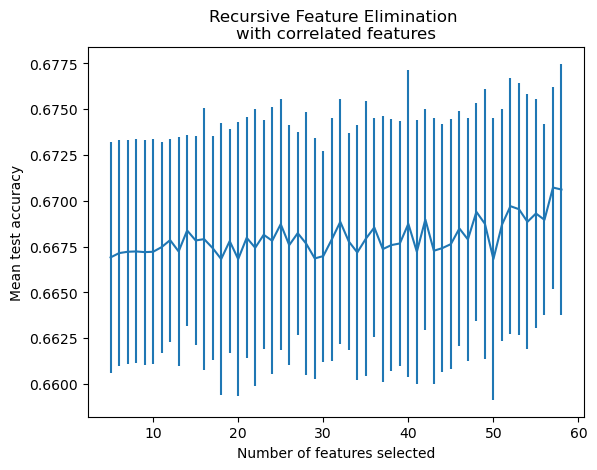

In [19]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [20]:
#Model4 （len(columns) descriptors）
Model4_clf=DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)
Model4_clf.fit(X_DT, y)
#Model4
Model4=Model_results(Model4_clf,X_DT,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.670505,0.000535
Accuracy_train,0.676936,0.000120
F1 Score,0.059181,0.003681
Precision,0.467348,0.017908
Recall,0.032274,0.002107
Roc_auc,0.521026,0.002410


In [21]:
Model4_clf=Model4_clf.fit(X_DT, y)
#Saving the final model
joblib.dump(Model4_clf, './DT.pkl')
DT= joblib.load(filename='./DT.pkl')

In [23]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_dt.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

FileNotFoundError: [Errno 2] No such file or directory: 'X_test_data.csv'

In [24]:
#Predicted results
Predicted_data=pd.DataFrame(DT.predict_proba(X_test),columns=['Probability of nonactivity','Probability of activity'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of activity" , inplace=True, ascending=False)
Predicted_data.to_csv("./DT_predict_data.csv",sep=',')
Predicted_data.head()

NameError: name 'X_test' is not defined

In [25]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./DT_model_data.csv",sep=',')
Model_data.columns = [['DecisionTree']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./DT_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/DT_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         DecisionTree                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.563532  0.001925  0.561131  0.002035  0.671196  0.000513   
Accuracy_train     0.997530  0.000030  0.997530  0.000030  0.677271  0.000148   
F1 Score           0.347534  0.003182  0.341974  0.003125  0.043380  0.002416   
Precision          0.341044  0.002853  0.336730  0.002882  0.503539  0.020141   
Recall             0.354795  0.003768  0.347990  0.003671  0.023018  0.001344   
Roc_auc            0.510386  0.002247  0.506749  0.002219  0.514494  0.002294   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.670505  0.000535  
Accuracy_train  0.676936  0.000120  
F1 Score        0.059181  0.003681  
Precision       0.467348  0.017908  
Recall          0.032274  0.002107  
Roc_auc         0.521026  0.002410

# LR

In [13]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.657811,0.001103
Accuracy_train,0.692657,0.000396
F1 Score,0.124038,0.003382
Precision,0.390773,0.007851
Recall,0.074423,0.002263
Roc_auc,0.503977,0.002402


In [14]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.674211,0.000699
Accuracy_train,0.677808,0.000101
F1 Score,0.076723,0.002472
Precision,0.551077,0.014655
Recall,0.041397,0.001377
Roc_auc,0.545715,0.002438


In [15]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    logreg_c = trial.suggest_float("logreg_c", 1e-3,  1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio",0.1,1,log=False) 
    #penalty = trial.suggest_categorical("penalty",['l1','l2'])
    max_iter = trial.suggest_int("max_iter", 100,2000)
    model =LogisticRegression(C=logreg_c,
                              max_iter=max_iter,
                              l1_ratio=l1_ratio,
                              solver='liblinear',random_state=1)
    
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=1))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-01 00:31:43,795] A new study created in memory with name: no-name-e190de33-fe73-45fd-994f-bed481db10bd
[I 2023-11-01 00:31:45,836] Trial 0 finished with value: 0.6746650387724797 and parameters: {'logreg_c': 0.3177840006884068, 'l1_ratio': 0.7482920440979423, 'max_iter': 100}. Best is trial 0 with value: 0.6746650387724797.
[I 2023-11-01 00:31:46,269] Trial 1 finished with value: 0.6741014684045535 and parameters: {'logreg_c': 0.0651621545821569, 'l1_ratio': 0.23208030173540176, 'max_iter': 275}. Best is trial 0 with value: 0.6746650387724797.
[I 2023-11-01 00:31:46,524] Trial 2 finished with value: 0.6725574657647252 and parameters: {'logreg_c': 0.013108749615263334, 'l1_ratio': 0.411004654338743, 'max_iter': 854}. Best is trial 0 with value: 0.6746650387724797.
[I 2023-11-01 00:31:47,344] Trial 3 finished with value: 0.6735574327668701 and parameters: {'logreg_c': 1.7096232052870346, 'l1_ratio': 0.4772750629629653, 'max_iter': 1402}. Best is trial 0 with value: 0.674665038

In [16]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=LogisticRegression(C=study.best_params['logreg_c'],
                              max_iter=study.best_params['max_iter'],
                              l1_ratio=study.best_params['l1_ratio'],
                              solver='liblinear',
                              random_state=1)

The best parameters are : 
{'logreg_c': 0.22314454351481386, 'l1_ratio': 0.854695836611055, 'max_iter': 298}


In [17]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.674901,0.000550
Accuracy_train,0.676908,0.000079
F1 Score,0.056606,0.002119
Precision,0.593338,0.017287
Recall,0.029829,0.001142
Roc_auc,0.546965,0.002410


In [18]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [19]:
data_lr=ML_data[columns]
data_lr.to_csv("./data_lr.csv",sep=',')
X_LR=np.array(data_lr)

In [26]:
data_lr

,SAscore,WiA_D/Dt,GATS3m,P_VSA_charge_1,QED,CATS2D_04_LL,JGI8,F04[O-O],HVcpx,nR=Cs,...,N-072,MaxssssC,F02[N-O],SpMax1_Bh(i),SHED_DD,JGI4,ChiA_B(e),GATS7m,MATS1i,SpMAD_EA(ri)
cid,,,,,,,,,,,,,,,,,,,,,
596.0,0.483975,0.742006,0.502577,0.299167,0.161443,0.200000,0.334059,0.0625,0.853155,0.0,...,0.250,0.938186,0.3,0.552128,0.458162,0.308730,0.560585,0.392684,0.516225,0.395336
1318.0,0.245427,0.359782,0.462730,0.058868,0.728096,0.036364,0.000000,0.0000,0.322976,0.2,...,0.000,0.938186,0.2,0.459245,0.075591,0.551648,0.022526,0.378666,0.842371,0.695037
1570.0,0.397823,0.112213,0.433900,0.377115,0.385073,0.000000,0.524238,0.1875,0.373882,0.1,...,0.125,0.938186,0.1,0.451751,0.340399,0.552143,0.203601,0.519568,0.738235,0.662042
1821.0,0.422965,0.355262,0.453423,0.252221,0.360650,0.000000,0.494443,0.0625,0.412350,0.0,...,0.000,0.938186,0.1,0.612418,0.572869,0.325000,0.288202,0.410171,0.516805,0.446648
2199.0,0.275540,0.403391,0.541115,0.108609,0.589147,0.072727,0.349377,0.0000,0.573399,0.2,...,0.000,0.938186,0.2,0.506044,0.075591,0.379048,0.140084,0.423520,0.644888,0.618684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135831485.0,0.226152,0.541122,0.499139,0.147976,0.701783,0.054545,0.311501,0.0625,0.593093,0.1,...,0.250,0.938186,0.3,0.291427,0.075591,0.368831,0.322847,0.553940,0.530707,0.371042
135900555.0,0.238547,0.476069,0.517294,0.051913,0.357297,0.018182,0.151137,0.0000,0.666921,0.0,...,0.125,0.938186,0.1,0.579004,0.000000,0.258687,0.280049,0.474916,0.580939,0.420020
135976680.0,0.204035,0.342174,0.657759,0.039367,0.834628,0.163636,0.429535,0.0000,0.352560,0.1,...,0.000,0.943586,0.0,0.376462,0.000000,0.437034,0.278942,0.400762,0.614055,0.684086


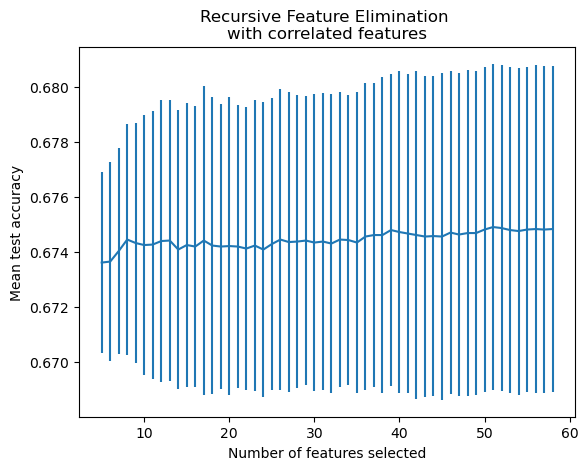

In [21]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [22]:
#Model4 （len(columns) descriptors）
Model4_clf=LogisticRegression(C=study.best_params['logreg_c'],max_iter=study.best_params['max_iter'],solver='liblinear',random_state=0)
#Model4
Model4=Model_results(Model4_clf,X_LR,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.675028,0.000568
Accuracy_train,0.676777,0.000072
F1 Score,0.056040,0.002139
Precision,0.598056,0.018198
Recall,0.029497,0.001147
Roc_auc,0.550614,0.002380


In [23]:
Model4_clf=Model4_clf.fit(X_LR, y)
#Saving the final model
joblib.dump(Model4_clf, './LogReg.pkl')


In [9]:
LogReg= joblib.load(filename='./LogReg.pkl')
data_lr=pd.read_csv("./data_lr.csv",sep=',',header=0,index_col=0)

In [10]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_lr.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()
#Predicted results
Predicted_data=pd.DataFrame(LogReg.predict_proba(X_test),columns=['Probability of nonactivity','Probability of activity'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of activity" , inplace=True, ascending=False)
Predicted_data.to_csv("./LR_predict_data.csv",sep=',')
Predicted_data.head()

,SAscore,WiA_D/Dt,GATS3m,P_VSA_charge_1,QED,CATS2D_04_LL,JGI8,F04[O-O],HVcpx,nR=Cs,...,N-072,MaxssssC,F02[N-O],SpMax1_Bh(i),SHED_DD,JGI4,ChiA_B(e),GATS7m,MATS1i,SpMAD_EA(ri)
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.568973,0.258075,0.492642,0.078551,0.668871,0.0,0.000000,0.0000,0.290348,0.0,...,0.0,0.938186,0.1,0.666467,0.075591,0.244925,0.292699,0.469021,0.341907,0.431500
13463,0.416488,0.344728,0.418994,0.231311,0.569863,0.0,0.431564,0.0000,0.382846,0.0,...,0.0,0.938186,0.1,0.591345,0.226772,0.354762,0.255172,0.477594,0.381909,0.401896
39148,0.401235,0.385603,0.504221,0.236901,0.562604,0.0,0.533799,0.0000,0.398024,0.0,...,0.0,0.938186,0.1,0.599190,0.226772,0.370306,0.285158,0.407432,0.280251,0.463901
56328,0.401220,0.330083,0.515223,0.154931,0.784274,0.0,0.477654,0.0000,0.375200,0.0,...,0.0,0.938186,0.1,0.594619,0.075591,0.340643,0.270593,0.476744,0.418685,0.423204
67358,0.502098,0.344091,0.463715,0.355712,0.246669,0.0,0.369912,0.0625,0.382369,0.0,...,0.0,0.938186,0.1,0.669016,0.453543,0.351094,0.227121,0.469638,0.413566,0.469428


PermissionError: [Errno 13] Permission denied: './LR_predict_data.csv'

In [27]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./LR_model_data.csv",sep=',')
Model_data.columns = [['LogisticRegression']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./LR_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         LogisticRegression                                          \
Model                     Model 1             Model 2             Model 3   
Values                       Mean        Se      Mean        Se      Mean   
Accuracy_test            0.657811  0.001103  0.674211  0.000699  0.674901   
Accuracy_train           0.692657  0.000396  0.677808  0.000101  0.676908   
F1 Score                 0.124038  0.003382  0.076723  0.002472  0.056606   
Precision                0.390773  0.007851  0.551077  0.014655  0.593338   
Recall                   0.074423  0.002263  0.041397  0.001377  0.029829   
Roc_auc                  0.503977  0.002402  0.545715  0.002438  0.546965   

Method                                        
Model                      Model 4            
Values                Se      Mean        Se  
Accuracy_test   0.000550  0.675028  0.000568  
Accuracy_train  0.000079  0.676777  0.000072  
F1 Score        0.002119  0.056040  0.002139  
Precision       0.017287  0.598056  0.018198  
Recall          0.001142  0.029497  0.001147  
Roc_auc         0.002410  0.550614  0.002380

In [ ]:
#Feature Importance
LR= joblib.load(filename='./LogReg.pkl')
data_lr=pd.read_csv("./data_lr.csv",sep=',',header=0,index_col=0)
X_LR=np.array(data_lr)
Raw_data = pd.read_csv('./Original_data.csv',index_col=0)
y=Raw_data['Activity'].values
columns=data_lr.columns

# RF

In [9]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.655377,0.001101
Accuracy_train,0.997522,0.000030
F1 Score,0.151023,0.003202
Precision,0.395135,0.006928
Recall,0.093805,0.002171
Roc_auc,0.529035,0.002396


In [10]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.658229,0.001041
Accuracy_train,0.997516,0.000029
F1 Score,0.144891,0.002891
Precision,0.406490,0.007220
Recall,0.088494,0.001901
Roc_auc,0.531042,0.002639


In [11]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators",100,1000,1) #整数型，(参数名称，下界，上界，步长)
    max_depth = trial.suggest_int("max_depth",5,20,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    #max_features = trial.suggest_categorical("max_features",["log2","sqrt","auto"]) #字符型
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease",0,5,log=False) #浮点型
    model = RandomForestClassifier(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_impurity_decrease = min_impurity_decrease
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)

[I 2023-11-28 05:27:10,537] A new study created in memory with name: no-name-193b3c11-2d08-41cb-a2ed-71cee0b49f70
[I 2023-11-28 05:27:41,845] Trial 0 finished with value: 0.6718129021613595 and parameters: {'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}. Best is trial 0 with value: 0.6718129021613595.
[I 2023-11-28 05:28:12,585] Trial 1 finished with value: 0.6718129021613595 and parameters: {'n_estimators': 481, 'max_depth': 15, 'max_features': 16, 'min_impurity_decrease': 4.4588650039103985}. Best is trial 0 with value: 0.6718129021613595.
[I 2023-11-28 05:29:33,730] Trial 2 finished with value: 0.6718129021613595 and parameters: {'n_estimators': 968, 'max_depth': 11, 'max_features': 25, 'min_impurity_decrease': 2.644474598764522}. Best is trial 0 with value: 0.6718129021613595.
[I 2023-11-28 05:29:58,776] Trial 3 finished with value: 0.6718129021613595 and parameters: {'n_estimators': 611, 'max_depth': 19, 'max_features': 6, 'mi

In [12]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

The best parameters are : 
{'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}


In [13]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.671813,0.000062
Accuracy_train,0.671813,0.000007
F1 Score,0.000000,0.000000
Precision,0.000000,0.000000
Recall,0.000000,0.000000
Roc_auc,0.500000,0.000000


In [14]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [15]:
data_rf=ML_data[columns]
data_rf.to_csv("./data_rf.csv",sep=',')
X_RF=np.array(data_rf)

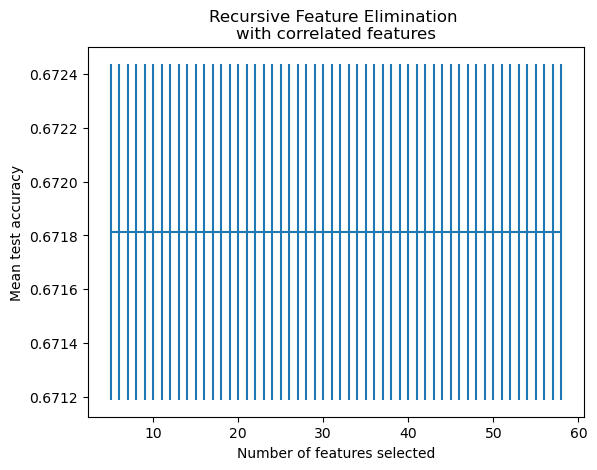

In [16]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [17]:
#Model4 （len(columns) descriptors）
Model4_clf=clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)
Model4_clf.fit(X_RF, y)
#Model4
Model4=Model_results(Model4_clf,X_RF,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.671813,0.000062
Accuracy_train,0.671813,0.000007
F1 Score,0.000000,0.000000
Precision,0.000000,0.000000
Recall,0.000000,0.000000
Roc_auc,0.500000,0.000000


In [18]:
Model4_clf=Model4_clf.fit(X_RF, y)
#Saving the final model
joblib.dump(Model4_clf, './RF.pkl')
RF= joblib.load(filename='./RF.pkl')

In [21]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./RF_model_data.csv",sep=',')
Model_data.columns = [['RandomForest']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./RF_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/RF_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         RandomForest                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.655377  0.001101  0.658229  0.001041  0.671813  0.000062   
Accuracy_train     0.997522  0.000030  0.997516  0.000029  0.671813  0.000007   
F1 Score           0.151023  0.003202  0.144891  0.002891  0.000000  0.000000   
Precision          0.395135  0.006928  0.406490  0.007220  0.000000  0.000000   
Recall             0.093805  0.002171  0.088494  0.001901  0.000000  0.000000   
Roc_auc            0.529035  0.002396  0.531042  0.002639  0.500000  0.000000   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.671813  0.000062  
Accuracy_train  0.671813  0.000007  
F1 Score        0.000000  0.000000  
Precision       0.000000  0.000000  
Recall          0.000000  0.000000  
Roc_auc         0.500000  0.000000

# XGBoost

In [21]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.628387,0.001418
Accuracy_train,0.997530,0.000030
F1 Score,0.234908,0.003572
Precision,0.361869,0.004501
Recall,0.174557,0.003051
Roc_auc,0.522498,0.002536


In [22]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.624136,0.001553
Accuracy_train,0.995910,0.000090
F1 Score,0.238779,0.003521
Precision,0.356177,0.004576
Recall,0.180252,0.003008
Roc_auc,0.513111,0.002650


In [23]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3,1.0,step=0.1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, step=0.005),
        'n_estimators': trial.suggest_int("n_estimators",50,1000,1)
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param,random_state=1,n_jobs=8)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-01 23:34:38,430] A new study created in memory with name: no-name-26f9c342-383a-4718-a995-bf2d6cd5db66
[I 2023-11-01 23:36:17,237] Trial 0 finished with value: 0.6299132816366937 and parameters: {'lambda': 0.15676677195506075, 'alpha': 0.7257005721594281, 'colsample_bytree': 0.7, 'subsample': 0.7000000000000001, 'learning_rate': 0.0801, 'n_estimators': 664}. Best is trial 0 with value: 0.6299132816366937.
[I 2023-11-01 23:37:50,806] Trial 1 finished with value: 0.6203575977561459 and parameters: {'lambda': 0.0562793204741517, 'alpha': 3.6905577292137624, 'colsample_bytree': 1.0, 'subsample': 0.6000000000000001, 'learning_rate': 0.1551, 'n_estimators': 552}. Best is trial 0 with value: 0.6299132816366937.
[I 2023-11-01 23:38:35,083] Trial 2 finished with value: 0.6731569048011877 and parameters: {'lambda': 0.18714500686240676, 'alpha': 5.039489598671215, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.0001, 'n_estimators': 841}. Best is trial 2 with value: 0.673

In [24]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)

The best parameters are : 
{'lambda': 0.07791822027030776, 'alpha': 0.024876057247133133, 'colsample_bytree': 0.3, 'subsample': 0.6000000000000001, 'learning_rate': 0.0001, 'n_estimators': 446}


In [25]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.674101,0.000429
Accuracy_train,0.684911,0.000160
F1 Score,0.038343,0.001660
Precision,0.626891,0.019873
Recall,0.019866,0.000875
Roc_auc,0.538356,0.002244


In [26]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [27]:
data_xgb=ML_data[columns]
data_xgb.to_csv("./data_xgb.csv",sep=',')
X_XGB=np.array(data_xgb)

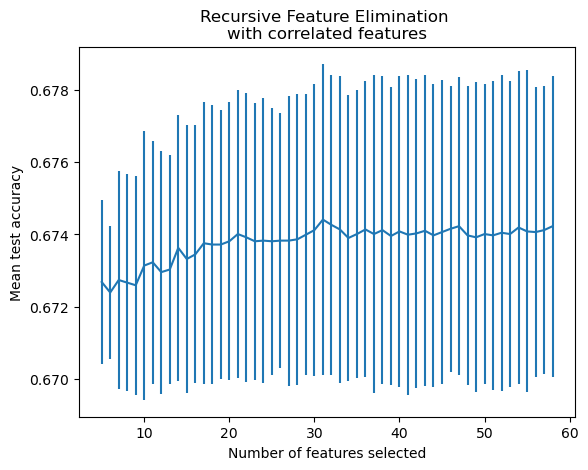

In [28]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [29]:
#Model4 （len(columns) descriptors）
Model4_clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)
Model4_clf.fit(X_XGB, y)
#Model4
Model4=Model_results(Model4_clf,X_XGB,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.674156,0.000409
Accuracy_train,0.683731,0.000161
F1 Score,0.037304,0.001692
Precision,0.623435,0.020337
Recall,0.019313,0.000891
Roc_auc,0.541815,0.002387


In [30]:
Model4_clf=Model4_clf.fit(X_XGB, y)
#Saving the final model
joblib.dump(Model4_clf, './XGB.pkl')
XGB= joblib.load(filename='./XGB.pkl')

In [31]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_xgb.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

FileNotFoundError: [Errno 2] No such file or directory: './X_test_data.csv'

In [32]:
#Predicted results
Predicted_data=pd.DataFrame(XGB.predict_proba(X_test),columns=['Probability of nonactivity','Probability of activity'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of Activity" ,inplace=True, ascending=False)
Predicted_data.to_csv("./XGB_predict_data.csv",sep=',')
Predicted_data.head()

NameError: name 'X_test' is not defined

In [33]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./XGB_model_data.csv",sep=',')
Model_data.columns = [['XGBoost']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./XGB_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method           XGBoost                                                    \
Model            Model 1             Model 2             Model 3             
Values              Mean        Se      Mean        Se      Mean        Se   
Accuracy_test   0.628387  0.001418  0.624136  0.001553  0.674101  0.000429   
Accuracy_train  0.997530  0.000030  0.995910  0.000090  0.684911  0.000160   
F1 Score        0.234908  0.003572  0.238779  0.003521  0.038343  0.001660   
Precision       0.361869  0.004501  0.356177  0.004576  0.626891  0.019873   
Recall          0.174557  0.003051  0.180252  0.003008  0.019866  0.000875   
Roc_auc         0.522498  0.002536  0.513111  0.002650  0.538356  0.002244   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.674156  0.000409  
Accuracy_train  0.683731  0.000161  
F1 Score        0.037304  0.001692  
Precision       0.623435  0.020337  
Recall          0.019313  0.000891  
Roc_auc         0.541815  0.002387